## Python (3.9.13)

In [1]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 numpy==1.26.4 matplotlib==3.9.0 keras==2.8.0 opencv-python==4.9.0.80 scikit-learn==1.5.0 pandas=2.2.2

  Using cached tensorflow-2.8.0-cp39-cp39-win_amd64.whl.metadata (2.9 kB)
  Using cached tensorflow_gpu-2.8.0-cp39-cp39-win_amd64.whl.metadata (2.9 kB)
  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl.metadata (61 kB)
  Using cached matplotlib-3.9.0-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached scikit_learn-1.5.0-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached pandas-2.2.2-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp39-cp39-win_amd64.whl.metadata (2.5 kB)
  Using

In [6]:
!pip install protobuf==3.20

  Using cached protobuf-3.20.0-cp39-cp39-win_amd64.whl.metadata (699 bytes)
Using cached protobuf-3.20.0-cp39-cp39-win_amd64.whl (904 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.27.0
    Uninstalling protobuf-5.27.0:
      Successfully uninstalled protobuf-5.27.0


  You can safely remove it manually.


In [1]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.3
certifi                      2024.2.2
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
exceptiongroup               1.2.1
executing                    2.0.1
filelock                     3.13.1
flatbuffers                  24.3.25
fonttools                    4.52.4
fsspec                       2024.2.0
gast                         0.5.4
google-auth                  2.29.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.64.0
h5py                         3.11.0
idna                         3.7
importlib_metadata         


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [5]:
################# Parameters #####################
path = "myData"  # folder with all the class folders
labelFile = "labels.csv"  # file with all names of classes
batch_size_val = 50  # how many to process together
steps_per_epoch_val = 2000
epochs_val = 100
imageDimensions = (32, 32, 3)
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation

In [6]:
############################### Importing of the Images
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [7]:
############################### Split Data
X_train, X_test, y_train, y_test = train_test_split(
    images, classNo, test_size=testRatio
)
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=validationRatio
)
steps_per_epoch_val = len(X_train) // batch_size_val
validation_steps = len(X_test) // batch_size_val

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [8]:
############################### TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
print("Data Shapes")
print("Train", end="")
print(X_train.shape, y_train.shape)
print("Validation", end="")
print(X_validation.shape, y_validation.shape)
print("Test", end="")
print(X_test.shape, y_test.shape)
assert (
    X_train.shape[0] == y_train.shape[0]
), "The number of images in not equal to the number of labels in training set"
assert (
    X_validation.shape[0] == y_validation.shape[0]
), "The number of images in not equal to the number of labels in validation set"
assert (
    X_test.shape[0] == y_test.shape[0]
), "The number of images in not equal to the number of labels in test set"
assert X_train.shape[1:] == (
    imageDimensions
), " The dimensions of the Training images are wrong "
assert X_validation.shape[1:] == (
    imageDimensions
), " The dimensions of the Validation images are wrong "
assert X_test.shape[1:] == (
    imageDimensions
), " The dimensions of the Test images are wrong"

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [9]:
############################### READ CSV FILE
data = pd.read_csv(labelFile)

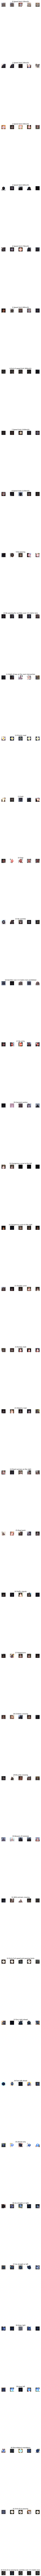

In [10]:
############################### DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(
            x_selected[random.randint(0, len(x_selected) - 1), :, :],
            cmap=plt.get_cmap("gray"),
        )
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["Name"])
            num_of_samples.append(len(x_selected))

[125, 1266, 1299, 787, 1121, 1050, 219, 835, 813, 857, 1126, 738, 1233, 1227, 415, 353, 228, 638, 691, 123, 194, 168, 216, 304, 148, 885, 343, 137, 311, 161, 254, 408, 123, 372, 232, 718, 203, 117, 1197, 172, 185, 143, 136]


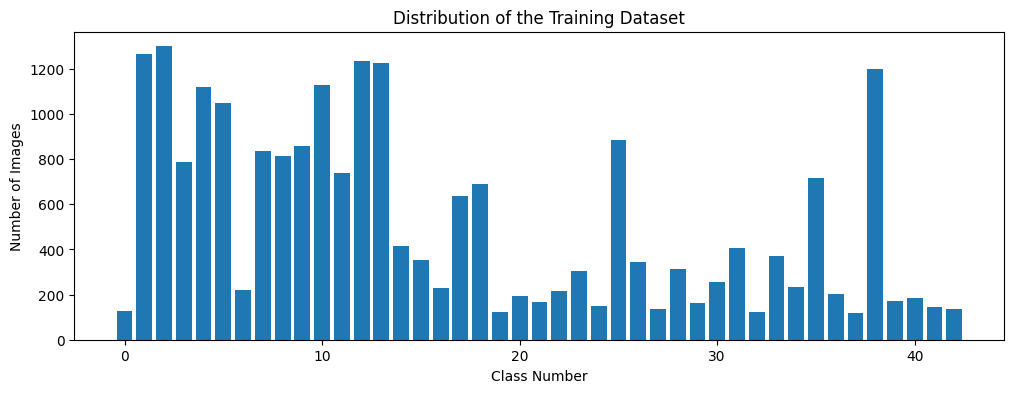

In [12]:
############################### DISPLAY A BAR CHART SHOWING NO OF SAMPLES FOR EACH CATEGORY
print(num_of_samples)
sum(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.show()

In [13]:
############################### PREPROCESSING THE IMAGES
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img


X_train = np.array(
    list(map(preprocessing, X_train))
)  # TO ITERATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [14]:
############################### ADD A DEPTH OF 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(
    X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1
)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

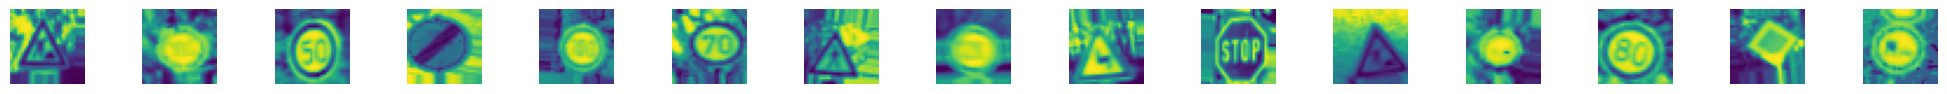

In [15]:
############################### AUGMENTATION OF IMAGES: TO MAKEIT MORE GENERIC
dataGen = ImageDataGenerator(
    width_shift_range=0.1,  # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFERS TO NO. OF  PIXELS EG 10 PIXELS
    height_shift_range=0.1,
    zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
    shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
    rotation_range=10,
)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(
    X_train, y_train, batch_size=20
)  # REQUESTING DATA GENERATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREATED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

# TO SHOW AUGMENTED IMAGE SAMPLES
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimensions[0], imageDimensions[1]))
    axs[i].axis("off")
plt.show()


y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [16]:
############################### CONVOLUTION NEURAL NETWORK MODEL
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (
        5,
        5,
    )  # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
    # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2 = (3, 3)
    size_of_pool = (
        2,
        2,
    )  # SCALE DOWN ALL FEATURE MAP TO GENERALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500  # NO. OF NODES IN HIDDEN LAYERS
    model = Sequential()
    model.add(
        (
            Conv2D(
                no_Of_Filters,
                size_of_Filter,
                input_shape=(imageDimensions[0], imageDimensions[1], 1),
                activation="relu",
            )
        )
    )  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation="relu")))
    model.add(
        MaxPooling2D(pool_size=size_of_pool)
    )  # DOES NOT EFFECT THE DEPTH/NO OF FILTERS

    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation="relu")))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation="relu")))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation="relu"))
    model.add(Dropout(0.5))  # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses, activation="softmax"))  # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(
        Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [17]:
checkpoint = ModelCheckpoint(
    "model_trained.h5",
    verbose=1,
    save_best_only=True,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=0.00001,
)

In [18]:
!nvidia-smi

Wed May 29 18:40:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8              1W /   85W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:
############################### TRAIN
model = myModel()
print(model.summary())
history = model.fit(
    dataGen.flow(X_train, y_train, batch_size=batch_size_val),
    steps_per_epoch=steps_per_epoch_val,
    epochs=epochs_val,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    validation_data=(X_validation, y_validation),
    shuffle=1,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

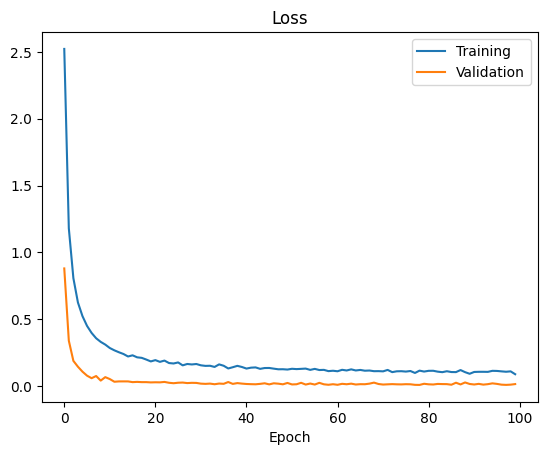

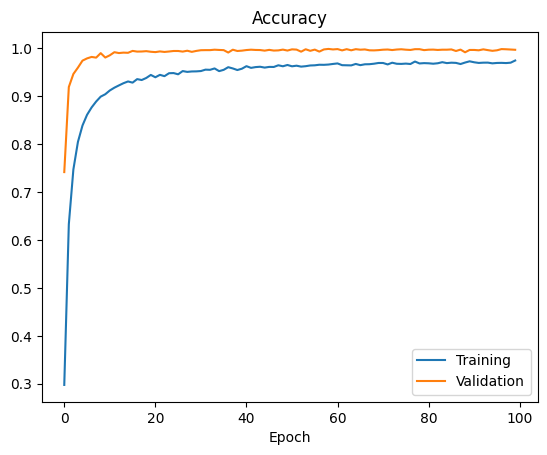

Test Score: 0.012892860919237137
Test Accuracy: 0.9961206912994385


In [20]:
############################### PLOT
plt.figure(1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.figure(2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Training", "Validation"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])